In [105]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("../Network-SDE-Inference/utils")
import LaGNA_flocks
import Self_func
import Interaction_func
from LaGNA_flocks import *
from Self_func import *
from Interaction_func import *

In [107]:
USE_CUDA = False

In [108]:
Timeseries = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Time series/flocks_timeseries_2dim_hf3.csv',encoding='utf-8',header=None)

In [109]:
Adj = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/adj_hf3_7.csv',encoding='utf-8',header=None)

In [110]:
model = 'flocks'

In [111]:
Num_nodes = Adj.shape[0]
Dimension = int(Timeseries.shape[1]/Num_nodes)

In [112]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [113]:
delt_t = 0.01

In [114]:
timeseries_t0 = timeseries[0:-1,:,:]
timeseries_t1 = timeseries[1:,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [115]:
timeseries_t2 = timeseries[2:,:,:]
dVdt = (timeseries_t2-2*timeseries_t1[:-1,:,:]+timeseries[0:-2,:,:])/delt_t**2

In [116]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [117]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [118]:
#data = data.reshape((10,-1,4,6))
import numpy as np
goal_data = np.concatenate([timeseries[3:,:,:],dXdt[1:-1,:,:],dVdt[:-1,:,:]],axis=2)
#goal_data = data[1:-1,:,0:Dimension]
mapping_data = np.concatenate((timeseries[1:-2,:,:],dXdt[0:-2,:,:]),axis=2)

In [119]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [122]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [123]:
aggr = 'add'
hidden = 100

msg_dim = 2
n_f = mapping_data.shape[2]

In [124]:
dim = Dimension*1

In [125]:
from torch_geometric.data import Data, DataLoader

In [127]:
ogn = SDI_Difftype(model,n_f, msg_dim, dim, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [128]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []

In [129]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [130]:
ogn.loss(_q)

tensor(714.3520, grad_fn=<AddBackward0>)

In [131]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [132]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [133]:
init_lr = 1e-4

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 30

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

In [134]:
epoch = 0
from tqdm import tqdm

In [135]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

In [136]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source

        s2 = tmp.x[tmp.edge_index[1]] #target

        #Tmp = torch.cat([s2, s1],dim=1) # tmp --> xi,xj
        xtmp = (s1[:,0:dim]-s2[:,0:dim])
        vtmp = (s1[:,dim:dim*2]-s2[:,dim:dim*2])
        if dim == 1:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2)
        if dim == 2:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2)
        if dim == 3:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2+(s1[:,2]-s2[:,2])**2)
 
        cohesion = ogn.msg_fnc_cohesion(Xtmp.reshape(-1,1))
        align = ogn.msg_fnc_align(Xtmp.reshape(-1,1))
        #repulsion = ogn.msg_fnc_repulsion(Xtmp.reshape(-1,1))
    
        all_messages = torch.cat((
            xtmp,vtmp,cohesion,align), dim=1)
        if dim == 1:
            columns = ['xij','dxij','c1','a1']
        if dim == 2:
            columns = ['xij','yij','dxij','dyij','c1','a1']
        elif dim == 3:
            columns = ['xij','yij','zij','dxij','dyij','dzij','c1','a1']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [137]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['xi','dxi','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['xi','yi','dxi','dyi','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['xi','yi','zi','dxi','dyi','dzi','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [138]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            vtmp = torch.sqrt(tmp[:,1]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,1:2],self_dyn), dim=1)
            columns = ['dxi','s1']
            
        if dim==2:
            vtmp = tmp[:,2]**2+tmp[:,3]**2
            vxtmp = torch.cat((vtmp.reshape(-1,1),tmp[:,2].reshape(-1,1)),dim=1)
            vytmp = torch.cat((vtmp.reshape(-1,1),tmp[:,3].reshape(-1,1)),dim=1)
            
            self_dyn_x = ogn.node_fnc_strength_x(vxtmp)#vtmp.reshape(-1,1)
            self_dyn_y = ogn.node_fnc_strength_y(vytmp)#vtmp.reshape(-1,1)
            self_dyn_all = torch.cat((vtmp.reshape(-1,1),tmp[:,2:4],self_dyn_x, self_dyn_y), dim=1)
            columns = ['Vi','dxi','dyi','s1','s2']
        if dim==3:
            vtmp = torch.sqrt(tmp[:,3]**2+tmp[:,4]**2+tmp[:,5]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,3:6],self_dyn), dim=1)
            columns = ['dxi','dyi','dzi','s1']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info

In [139]:
recorded_models = []

In [140]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            #(loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(copy(ogn.state_dict()))

  0%|                                                    | 0/30 [00:00<?, ?it/s]

103.23290556375957
5.801830573583369


  3%|█▍                                          | 1/30 [01:34<45:37, 94.40s/it]

3.8789504966794848
0.9863277045777155


  7%|██▉                                         | 2/30 [03:10<44:35, 95.54s/it]

-5.691206241678355
-15.587059767776033


 10%|████▍                                       | 3/30 [04:45<42:44, 95.00s/it]

-35.64012503176548
-62.39477107823381


 13%|█████▊                                      | 4/30 [06:19<40:58, 94.58s/it]

-100.20973815951348
-127.71601413488239


 17%|███████▎                                    | 5/30 [07:53<39:19, 94.40s/it]

-130.63096812707238
-134.36541669639763


 20%|████████▊                                   | 6/30 [09:27<37:42, 94.26s/it]

-131.2299909819219
-138.32285951106886


 23%|██████████▎                                 | 7/30 [11:00<36:04, 94.12s/it]

-132.43611027894573
-137.72082714592847


 27%|███████████▋                                | 8/30 [12:34<34:28, 94.04s/it]

-129.87081536156072
-139.58157180344375


 30%|█████████████▏                              | 9/30 [14:08<32:53, 93.96s/it]

-133.27784054936367
-138.60437936157732


 33%|██████████████▎                            | 10/30 [15:42<31:18, 93.93s/it]

-133.08431008919382
-120.32020798140651


 37%|███████████████▊                           | 11/30 [17:16<29:43, 93.89s/it]

-137.78373487325874
-143.11768380554864


 40%|█████████████████▏                         | 12/30 [18:48<28:03, 93.52s/it]

-139.26234617867928
-137.94460140868438


 43%|██████████████████▋                        | 13/30 [20:20<26:19, 92.89s/it]

-142.67101638024556
-147.91814711279463


 47%|████████████████████                       | 14/30 [21:51<24:39, 92.48s/it]

-145.19492778939906
-152.48643294957247


 50%|█████████████████████▌                     | 15/30 [23:23<23:02, 92.18s/it]

-147.07308888672668
-153.54254835401056


 53%|██████████████████████▉                    | 16/30 [24:55<21:29, 92.09s/it]

-150.5973733397625
-154.89837826247023


 57%|████████████████████████▎                  | 17/30 [26:26<19:55, 91.94s/it]

-154.43122940970673
-158.6203268748923


 60%|█████████████████████████▊                 | 18/30 [27:58<18:21, 91.79s/it]

-157.20317522508896
-148.7325143571455


 63%|███████████████████████████▏               | 19/30 [29:29<16:48, 91.66s/it]

-159.45661237682074
-163.517642743935


 67%|████████████████████████████▋              | 20/30 [31:00<15:15, 91.55s/it]

-163.24712467660018
-167.1249903578375


 70%|██████████████████████████████             | 21/30 [32:32<13:44, 91.57s/it]

-164.9339191335021
-163.1998456435509


 73%|███████████████████████████████▌           | 22/30 [34:04<12:13, 91.67s/it]

-167.30548386101492
-165.33647678794532


 77%|████████████████████████████████▉          | 23/30 [35:35<10:40, 91.55s/it]

-168.78421945252563
-170.3498823005972


 80%|██████████████████████████████████▍        | 24/30 [37:06<09:08, 91.45s/it]

-169.92844143255655
-169.96279443668413


 83%|███████████████████████████████████▊       | 25/30 [38:38<07:36, 91.38s/it]

-170.91949530125714
-171.63396364645428


 87%|█████████████████████████████████████▎     | 26/30 [40:09<06:05, 91.32s/it]

-171.75052415522362
-171.50475243868303


 90%|██████████████████████████████████████▋    | 27/30 [41:40<04:33, 91.32s/it]

-172.21725932271647
-172.17735573749133


 93%|████████████████████████████████████████▏  | 28/30 [43:11<03:02, 91.28s/it]

-172.54093458430503
-172.22141442285144


 97%|█████████████████████████████████████████▌ | 29/30 [44:42<01:31, 91.24s/it]

-172.65736349701265
-172.33126451640757


100%|███████████████████████████████████████████| 30/30 [46:14<00:00, 92.48s/it]


In [142]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [143]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
vx_Update = []
vy_Update = []
vz_Update = []
for i in range(0,20000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp,v_tmp= ogn.sample_trajectories(_q)
    if i < X.shape[0]-2:
        X[i+2,:,0:dim] = x_tmp
        
        X[i+1,:,dim:] = v_tmp
    else:
        break
    x_Update.append(x_tmp[:,0].reshape(1,-1))
    y_Update.append(x_tmp[:,1].reshape(1,-1))
    #z_Update.append(x_tmp[:,2].reshape(1,-1))
    vx_Update.append(v_tmp[:,0].reshape(1,-1))
    vy_Update.append(v_tmp[:,1].reshape(1,-1))
    #vz_Update.append(v_tmp[:,2].reshape(1,-1))
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
#z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)
vx_i = torch.stack(vx_Update, dim=0).reshape(-1,Num_nodes)
vy_i = torch.stack(vy_Update, dim=0).reshape(-1,Num_nodes)
#vz_i = torch.stack(vz_Update, dim=0).reshape(-1,Num_nodes)

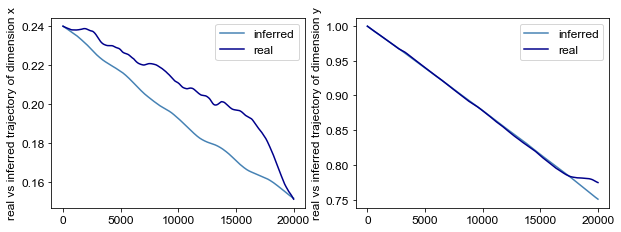

In [144]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/pigeonflocks_trajectories/hf3/flocks_timeseries_2dim_hf3.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
#plt.rcParams['savefig.dpi'] = 300 
#plt.rcParams['figure.dpi'] = 300
Nindex =0
TIME = 20000
x_tra = x_i.detach().numpy()[0:TIME,Nindex-1]
x_real = time1.iloc[0:,Nindex*2-2]
fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(1,2,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[2:x_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
y_tra = y_i.detach().numpy()[0:TIME,Nindex-1]
y_real = time1.iloc[0:,Nindex*2-1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[2:y_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_average_trajectories.png')
plt.show()
#plt.close()

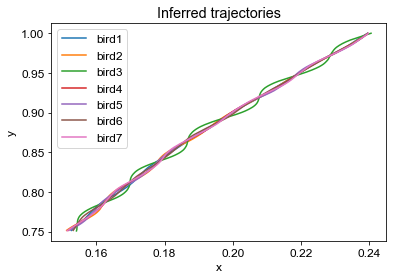

In [180]:
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

r = np.linspace(0, 200, 20000)
fig, ax = plt.subplots()
x1 = x_i.detach().numpy()[0:TIME,0]
y1 = y_i.detach().numpy()[0:TIME,0]
ax.plot(x1, y1, label='bird1')
#ax.scatter(x1, y1, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x2 = x_i.detach().numpy()[0:TIME,1]
y2 = y_i.detach().numpy()[0:TIME,1]
ax.plot(x2, y2, label='bird2')
#ax.scatter(x2, y2, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x3 = x_i.detach().numpy()[0:TIME,2]
y3 = y_i.detach().numpy()[0:TIME,2]
ax.plot(x3, y3, label='bird3')
#ax.scatter(x3, y3, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x4 = x_i.detach().numpy()[0:TIME,3]
y4 = y_i.detach().numpy()[0:TIME,3]
ax.plot(x4, y4, label='bird4')
#ax.scatter(x4, y4, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x5 = x_i.detach().numpy()[0:TIME,4]
y5 = y_i.detach().numpy()[0:TIME,4]
ax.plot(x5, y5, label='bird5')
#ax.scatter(x5, y5, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x6 = x_i.detach().numpy()[0:TIME,5]
y6 = y_i.detach().numpy()[0:TIME,5]
ax.plot(x6, y6, label='bird6')
#ax.scatter(x6, y6, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x7 = x_i.detach().numpy()[0:TIME,6]
y7 = y_i.detach().numpy()[0:TIME,6]
ax.plot(x7, y7, label='bird7')
#ax.scatter(x7, y7, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)


# x = x_real[1:20001,]
# y = y_real[1:20001,]
# ax.scatter(x, y, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inferred trajectories')
ax.legend()
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf3_inferred.pdf')
plt.show()

/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_31238/2751892123.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


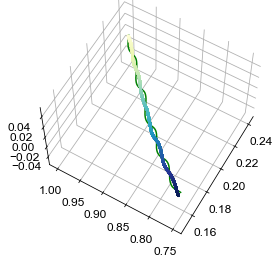

In [146]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.azim = -150
ax.dist = 9
ax.elev = 60
r = np.linspace(0, 200, 20000)


x_tra_1 = x_i.detach().numpy()[0:TIME,Nindex+1]
y_tra_1 = y_i.detach().numpy()[0:TIME,Nindex+1]
#z_tra_1 = z_i.detach().numpy()[0:TIME,Nindex+1]
x = x_tra_1#x_real[1:x_tra.shape[0]+1,]
y = y_tra_1#y_real[1:y_tra.shape[0]+1,]
#z = z_tra_1#z_real[1:z_tra.shape[0]+1,]

x_tra_2 = x_i.detach().numpy()[0:TIME,Nindex+2]
y_tra_2 = y_i.detach().numpy()[0:TIME,Nindex+2]
#z_tra_2 = z_i.detach().numpy()[0:TIME,Nindex+2]
x2 = x_tra_2#x_real[1:x_tra.shape[0]+1,]
y2 = y_tra_2 #y_real[1:y_tra.shape[0]+1,]
#z2 = z_tra_2#z_real[1:z_tra.shape[0]+1,]

x_tra_3 = x_i.detach().numpy()[0:TIME,Nindex+3]
y_tra_3 = y_i.detach().numpy()[0:TIME,Nindex+3]
#z_tra_3 = z_i.detach().numpy()[0:TIME,Nindex+3]
x3 = x_tra_3#x_real[1:x_tra.shape[0]+1,]
y3 = y_tra_3 #y_real[1:y_tra.shape[0]+1,]
#z3 = z_tra_3#z_real[1:z_tra.shape[0]+1,]


x1 = x_tra
y1 = y_tra
#z1 = z_tra

#1 colored by value of `z`
ax.plot(x, y, c = 'k') 
ax.plot(x2, y2, c = 'g') 
ax.plot(x3, y3, c = 'b') 
#2 colored by index (same in this example since z is a linspace too)

ax.scatter(x1, y1, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 3)

plt.show()

In [148]:
bestMe = messages_over_time[-1]

In [149]:
bestMe

,xij,yij,dxij,dyij,c1,a1,epoch,loss
0,-0.000538,-0.000151,-0.000074,0.000082,0.004006,0.001113,29,-172.657363
1,0.001494,0.002371,0.000162,0.000086,0.002951,0.001110,29,-172.657363
2,-0.000657,0.000019,-0.000115,0.000107,0.003960,0.001113,29,-172.657363
3,-0.000337,-0.000382,-0.000027,0.000056,0.004029,0.001113,29,-172.657363
4,-0.000461,-0.000148,-0.000038,0.000085,0.004041,0.001113,29,-172.657363
...,...,...,...,...,...,...,...,...
41995,0.000349,-0.000028,0.000034,-0.000024,0.004104,0.001113,29,-172.657363
41996,0.002710,0.000141,0.000160,-0.000093,0.002992,0.001110,29,-172.657363
41997,0.001058,-0.000413,-0.000049,0.000070,0.003734,0.001112,29,-172.657363
41998,0.000715,-0.000499,-0.000085,0.000082,0.003858,0.001113,29,-172.657363


In [150]:
rij_val = np.sqrt(bestMe['xij'].values**2+bestMe['yij'].values**2)
#cohesion_true = 1.5*(1-(rij_val/2)**3)/(1+(rij_val/2)**6) # x1 (x_i) is target, x2 (x_j) is source 
align_true = np.exp(-rij_val/3)#np.sin(bestMe['x2'].values-bestMe['x1'].values)

In [151]:
maxy = np.max(bestMe['a1'].values)
miny = np.min(bestMe['a1'].values)
maxx = np.max(align_true)
minx = np.min(align_true)
align_true = (maxy-miny)*(align_true-minx)/(maxx-minx) + miny

In [152]:
(maxy-miny)/(maxx-minx)

0.004008455

In [153]:
minx

0.99722046

In [154]:
maxx-minx

0.0027792454

In [155]:
miny

0.0011027143

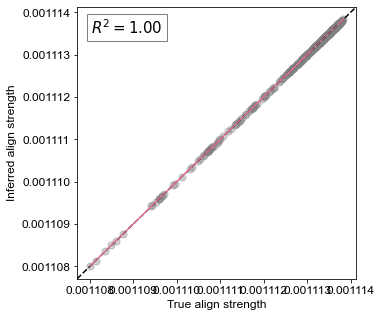

In [188]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sx = bestMe['a1'].values[0:1000]#*bestMe['dxij']*m2
sx_true = align_true[0:1000]#*bestMe['dxij']
sy = bestMe['a1'].values[0:5000]#*bestMe['dyij']*m2
sy_true = align_true[0:5000]#*bestMe['dyij']
#sz = bestMe['a1'].values#*bestMe['dzij']*m2
#sz_true = align_true#*bestMe['dzij']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1,1,1)
#plt.title("true align- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True align strength")
plt.ylabel("Inferred align strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf3_align.pdf')

In [181]:
coup_value = -((rij_val/2-1)**3/(1+rij_val/2)**6)+1
#coup_value = ((rij_val/0.1)**3-1)/((rij_val/0.1)**6+1)

In [182]:
maxy = np.max(bestMe['c1'].values)
miny = np.min(bestMe['c1'].values)
maxx = np.max(coup_value)
minx = np.min(coup_value)
coup_value = (maxy-miny)*(coup_value-minx)/(maxx-minx) + miny

In [183]:
(maxy-miny)/(maxx-minx)

0.106570505

In [192]:
minx

1.9631455

In [185]:
maxx-minx

0.036850452

In [186]:
miny

0.00034091622

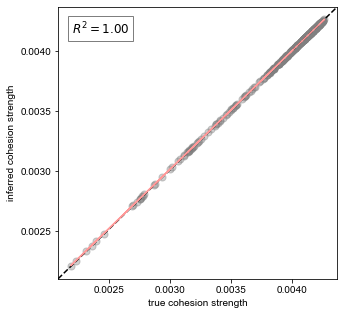

In [189]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
temp = bestMe['c1'].values[0:1000]
coup_value = coup_value[0:1000]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=50,c ='grey', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.5)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
#plt.title('Relation-rij-cohesion')
plt.xlabel("true cohesion strength")
plt.ylabel("inferred cohesion strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf3_cohesion.pdf')

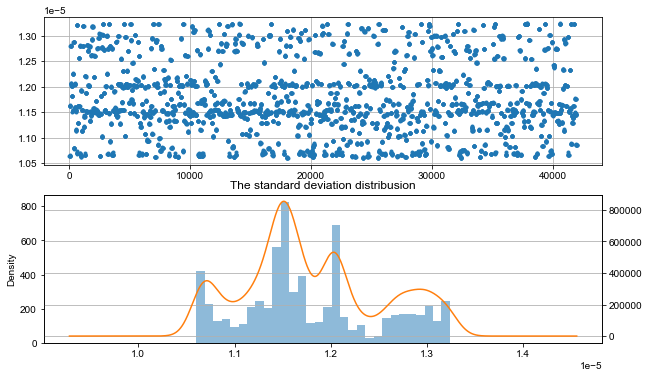

In [164]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(0.01) # diffusion is sqrt(h)*theta(x0) 

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)
#ax1.scatter(s.index, s.values)
ax1.plot(s.index, s.values,'.')
plt.grid()
 
ax2 = fig.add_subplot(2,1,2) 
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.title('The standard deviation distribusion')
plt.grid()

In [165]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)
TimeSeries = best_selfDyn.iloc[:,0:dim].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [166]:
best_selfDyn

,Vi,dxi,dyi,s1,s2
0,0.000002,-0.000315,-0.001209,-0.000005,-0.000020
1,0.000002,-0.000315,-0.001209,-0.000005,-0.000020
2,0.000002,-0.000315,-0.001209,-0.000005,-0.000020
3,0.000002,-0.000315,-0.001209,-0.000005,-0.000020
4,0.000002,-0.000315,-0.001209,-0.000005,-0.000020
...,...,...,...,...,...
41995,0.000001,-0.000733,-0.000929,-0.000005,-0.000016
41996,0.000001,-0.000733,-0.000929,-0.000005,-0.000016
41997,0.000001,-0.000733,-0.000929,-0.000005,-0.000016
41998,0.000001,-0.000733,-0.000929,-0.000005,-0.000016


In [167]:
self_true = (best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
#self_true = best_selfDyn['dxi']*best_selfDyn['Vi']
self_true_1 = np.sqrt(best_selfDyn['Vi'])*best_selfDyn['dxi']
self_true_2 = best_selfDyn['dxi']

In [168]:
maxy = np.max(best_selfDyn['s1'].values)
miny = np.min(best_selfDyn['s1'].values)
maxx = np.max(self_true)
minx = np.min(self_true)
self_true = (maxy-miny)*(self_true-minx)/(maxx-minx) + miny

In [169]:
(maxy-miny)/(maxx-minx)

0.29124801565443115

In [170]:
minx

7.389401162072318e-07

In [171]:
maxx-minx

1.9441990843915846e-06

In [172]:
miny

-5.2824616e-06

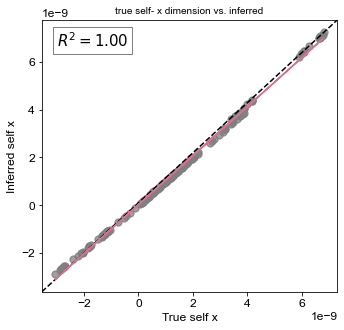

In [190]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#self_true = 0.4*(-np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2))
ri = np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
sx = best_selfDyn['s1'].values*best_selfDyn['dxi']
sx_true = self_true*best_selfDyn['dxi']
sx = sx[0:1000]
sx_true = sx_true[0:1000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf3_self.pdf')